Trabalho Prático 1 - DCC207 - Algoritmos II

Arthur Veloso Kuahara - Matrícula - 2018054370

Nesse trabalho serão abordados os aspectos práticos de geometria computacional.
Especificamente, serão explorados aspectos de implementação do problema da galeria
de arte (triangulação de polígonos). 

In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from functools import reduce
from itertools import chain
from plotnine import ggplot, aes, geom_polygon, geom_segment, geom_point

import math
import sys
from collections import namedtuple
Point = namedtuple('Point', ['x', 'y'])
EPSILON = math.sqrt(sys.float_info.epsilon)

In [2]:
#Funções auxiliares

def sentido_horario(polygon):
    s = 0
    n_poligonos = len(polygon)
    for i in range(n_poligonos):
        point = polygon[i]
        point2 = polygon[(i + 1) % n_poligonos]
        s += (point2.x - point.x) * (point2.y + point.y)
    return s > 0

def area_triangulo(x1, y1, x2, y2, x3, y3):
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2.0)


def soma_triangulo(x1, y1, x2, y2, x3, y3):
    return x1 * (y3 - y2) + x2 * (y1 - y3) + x3 * (y2 - y1)

def calculate_total_area(triangles):
    result = []
    for triangle in triangles:
        sides = []
        for i in range(3):
            next_index = (i + 1) % 3
            pt = triangle[i]
            pt2 = triangle[next_index]
            side = math.sqrt(math.pow(pt2[0] - pt[0], 2) + math.pow(pt2[1] - pt[1], 2))
            sides.append(side)
        c, b, a = sorted(sides)
        area = .25 * math.sqrt(abs((a + (b + c)) * (c - (a - b)) * (c + (a - b)) * (a + (b - c))))
        result.append((area, a, b, c))
    triangle_area = sum(tri[0] for tri in result)
    return triangle_area

def contem(p, a, b, c):
    area = area_triangulo(a.x, a.y, b.x, b.y, c.x, c.y)
    area1 = area_triangulo(p.x, p.y, b.x, b.y, c.x, c.y)
    area2 = area_triangulo(p.x, p.y, a.x, a.y, c.x, c.y)
    area3 = area_triangulo(p.x, p.y, a.x, a.y, b.x, b.y)
    areadiff = abs(area - sum([area1, area2, area3])) < EPSILON
    return areadiff

def naocontem(p1, p2, p3, polygon):
    for pn in polygon:
        if pn in (p1, p2, p3):
            continue
        elif contem(pn, p1, p2, p3):
            return False
    return True

def _is_ear(p1, p2, p3, polygon):
    ear = naocontem(p1, p2, p3, polygon) and \
        eh_convexo(p1, p2, p3) and \
        area_triangulo(p1.x, p1.y, p2.x, p2.y, p3.x, p3.y) > 0
    return ear

def eh_convexo(prev, point, next):
    return soma_triangulo(prev.x, prev.y, point.x, point.y, next.x, next.y) < 0

In [3]:
#Implementação do Algoritmo

def earclip(polygon):
    
    ear_vertex = []
    triangles = []

    polygon = [Point(*point) for point in polygon]

    if sentido_horario(polygon):
        polygon.reverse()

    point_count = len(polygon)
    for i in range(point_count):
        prev_index = i - 1
        prev_point = polygon[prev_index]
        point = polygon[i]
        next_index = (i + 1) % point_count
        next_point = polygon[next_index]

        if _is_ear(prev_point, point, next_point, polygon):
            ear_vertex.append(point)

    while ear_vertex and point_count >= 3:
        ear = ear_vertex.pop(0)
        i = polygon.index(ear)
        prev_index = i - 1
        prev_point = polygon[prev_index]
        next_index = (i + 1) % point_count
        next_point = polygon[next_index]

        polygon.remove(ear)
        point_count -= 1
        triangles.append(((prev_point.x, prev_point.y), (ear.x, ear.y), (next_point.x, next_point.y)))
        if point_count > 3:
            prev_prev_point = polygon[prev_index - 1]
            next_next_index = (i + 1) % point_count
            next_next_point = polygon[next_next_index]

            groups = [
                (prev_prev_point, prev_point, next_point, polygon),
                (prev_point, next_point, next_next_point, polygon),
            ]
            for group in groups:
                p = group[1]
                if _is_ear(*group):
                    if p not in ear_vertex:
                        ear_vertex.append(p)
                elif p in ear_vertex:
                    ear_vertex.remove(p)
    return triangles

In [4]:
#Polígonos de teste

crista = [[(0.5*a,10), (0.5*(a+1),2), (0.5*(a+2),2)] for a in range(1,25,3)]
points = [(0,0)] + list(reduce(lambda x,y: x+y, crista)) + [(12,0),(0,0)]
del points[-3]
del points[-3]

points2 = [(0,0), (1,3), (4,-2),(6.5,4),(2,4.5),(7.5,7),(1.5,7.5),(0.6,5),(-0.8,6),(0,0)]
points3 = [(np.cos((2*k*np.pi)/8),np.sin((2*k*np.pi)/8)) for k in range(1,9)]
points4 = [(3,4), (2,2), (3.5025,1.02125), (3.8025,2.64125), (4.7825,1.22125), (6.2225,1.20125), (6.5225,2.42125), (5.6025,3.58125), (5.0625,2.52125), (4.3425,3.48125), (5.3825,4.68125)]

In [5]:
def make_frame_from_polygon(polygon):
    x = [i[0] for i in polygon]
    y = [i[1] for i in polygon]
    df = pd.DataFrame({'x': x, 'y': y})
    return df

def make_frame_from_triangles(triangles):
    x_start = []
    x_end = []
    y_start = []
    y_end = []
    for triangle in triangles:
        for i, pt in enumerate(triangle):
            next_index = (i + 1) % 3
            x_start.append(pt[0])
            x_end.append(triangle[next_index][0])
            y_start.append(pt[1])
            y_end.append(triangle[next_index][1])
    df = pd.DataFrame({'x': x_start, 'y': y_start, 'xend': x_end, 'yend': y_end})
    return df

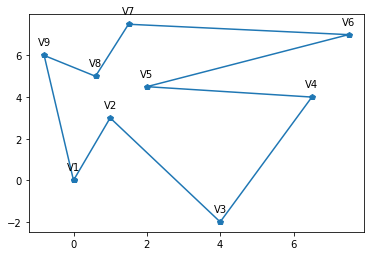

In [6]:
#Polígono inicial

plt.plot([a[0] for a in points2],[a[1] for a in points2],'p-')
i = 0
for x,y in points2[:-1]:
    i += 1
    label = "V{}".format(i)

    plt.annotate(label, (x,y),textcoords="offset points",xytext=(0,10),ha='center') 

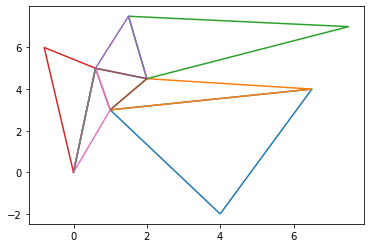

In [7]:
triangles2= earclip(points)
#print(triangles2)#Lista contendo os triângulos

plt.plot([1,4,6.5,1], [3,-2,4,3])
plt.plot([1,6.5,2,1], [3,4,4.5,3])
plt.plot([2,7.5,1.5,2],[4.5,7,7.5,4.5])
plt.plot([0.6,-0.8,0,0.6],[5,6,0,5])
plt.plot([2,1.5,0.6,2],[4.5, 7.5, 5, 4.5])
plt.plot([1,2,0.6,1],[3,4.5,5,3])
plt.plot([0,1,0.6,0],[0,3,5,0])
plt.plot([0,0.6,0,0],[0,5,0,0])

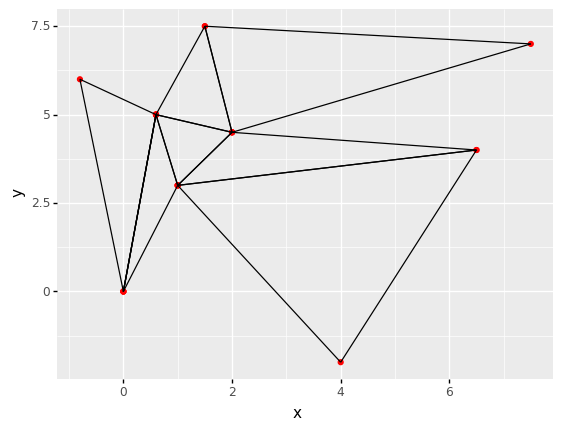

<ggplot: (169725008634)>

In [8]:
triangles5 = earclip(points2)
df = make_frame_from_triangles(triangles5)
(ggplot(df, aes(x='x', y='y')) + geom_point(color='red') + geom_segment(aes(x='x', y='y', xend='xend', yend='yend')))

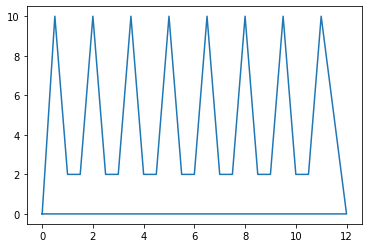

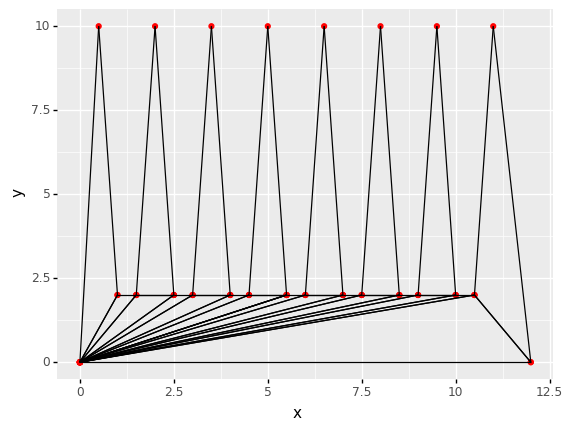

<ggplot: (169725188346)>

In [9]:
plt.plot([a[0] for a in points],[a[1] for a in points])

triangles2 = earclip(points)
df = make_frame_from_triangles(triangles2)
(ggplot(df, aes(x='x', y='y')) + geom_point(color='red') + geom_segment(aes(x='x', y='y', xend='xend', yend='yend')))

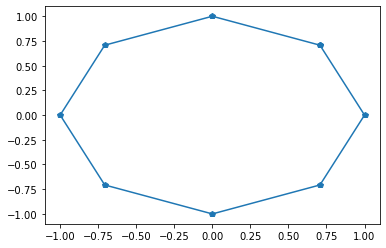

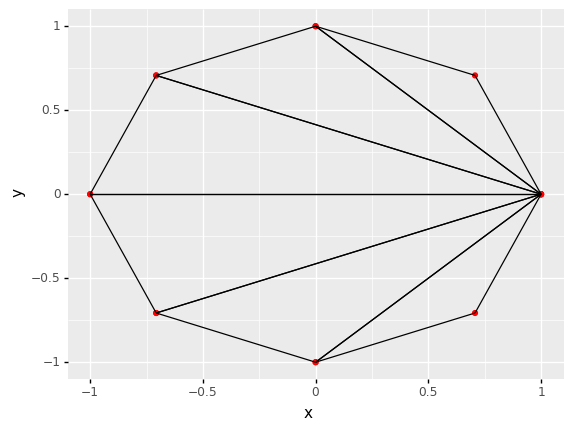

<ggplot: (169725154042)>

In [10]:
#Plotting v2 - sem fazer manualmente

plt.plot([a[0] for a in points3]+[points3[0][0]],[a[1] for a in points3]+[points3[0][1]],'p-')


triangles = earclip(points3)
df = make_frame_from_triangles(triangles)
(ggplot(df, aes(x='x', y='y')) + geom_point(color='red') + geom_segment(aes(x='x', y='y', xend='xend', yend='yend')))

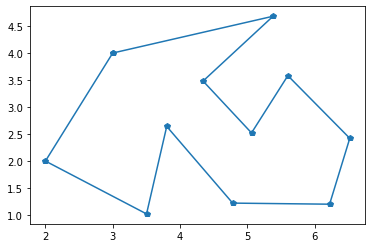

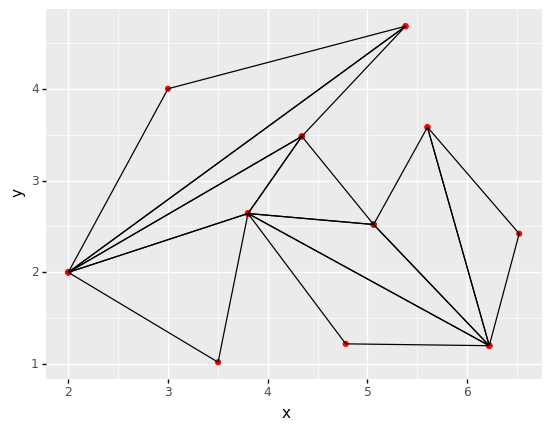

<ggplot: (169726266362)>

In [11]:
plt.plot([a[0] for a in points4]+[points4[0][0]],[a[1] for a in points4]+[points4[0][1]],'p-')
triangles4 = earclip(points4)

df = make_frame_from_triangles(triangles4)
(ggplot(df, aes(x='x', y='y')) + geom_point(color='red') + geom_segment(aes(x='x', y='y', xend='xend', yend='yend')))

In [12]:
#Agora, temos que converter os polígonos triangulados para grafos, de modo a podermos fazer a 3-coloração
#Para isso, vamos usar um dicionário

In [13]:
class Graph:
    def __init__(self, edges, N):
        self.adj = [[] for _ in range(N)]
        for (src, dest) in edges:
            self.adj[src].append(dest)
            self.adj[dest].append(src)

def colorGraph(graph):
    result = {}
    for u in range(N):
        assigned = set([result.get(i) for i in graph.adj[u] if i in result])
        color = 1
        for c in assigned:
            if color != c:
                break
            color = color + 1
        result[u] = color
 
    for v in range(N):
        print("A cor do vértice", v, "eh", colors[result[v]])
    
#A Princípio de demonstração, vamos nomear os vértices do grafo exemplo

![alt text](grafo_nomeado.png "Grafo com os pontos nomeados")

In [14]:
#Agora, podemos criar o grafo no Python

In [15]:
colors = ["", "azul", "verde", "vermelho", "amarelo"]
edges = [(0, 1), (0, 8), (1, 0), (1, 8), (1, 2), (2, 1), (2, 8), (2, 5), (2, 4), (2,3), (3,2), (3,4), (4,3), (4,2), (4,5), (5,4), (5,2), (5,7), (5,6), (5,8), (6,5), (6,7), (7,5), (7,6), (7,8), (8,0), (8,1), (8,2), (8,5), (8,7), (8,6)]
N = 9
graph = Graph(edges, N)
colorGraph(graph)

A cor do vértice 0 eh azul
A cor do vértice 1 eh verde
A cor do vértice 2 eh azul
A cor do vértice 3 eh verde
A cor do vértice 4 eh vermelho
A cor do vértice 5 eh verde
A cor do vértice 6 eh azul
A cor do vértice 7 eh vermelho
A cor do vértice 8 eh amarelo



![alt text](grafo_colorizado.png "Grafo colorizado")

In [16]:
# Como conseguimos 3-colorizar com apenas 2 pontos vermelhos, o problema da galeria de arte está solucionado.
# Basta colocar apenas dois guardas, nos pontos 4 e 7, e eles terão a visão da galeria inteira.